# Домашнее задание "Модели авторегрессии условной гетероскедантичности"
Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model

In [2]:
# Загружаем временной ряд
series = pd.read_csv('daily-total-female-births-in-cal.csv')['Count']

In [3]:
# Функция, являющаяся тестом на стационарность ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
# Функция, позволяющая визуализировать графики
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


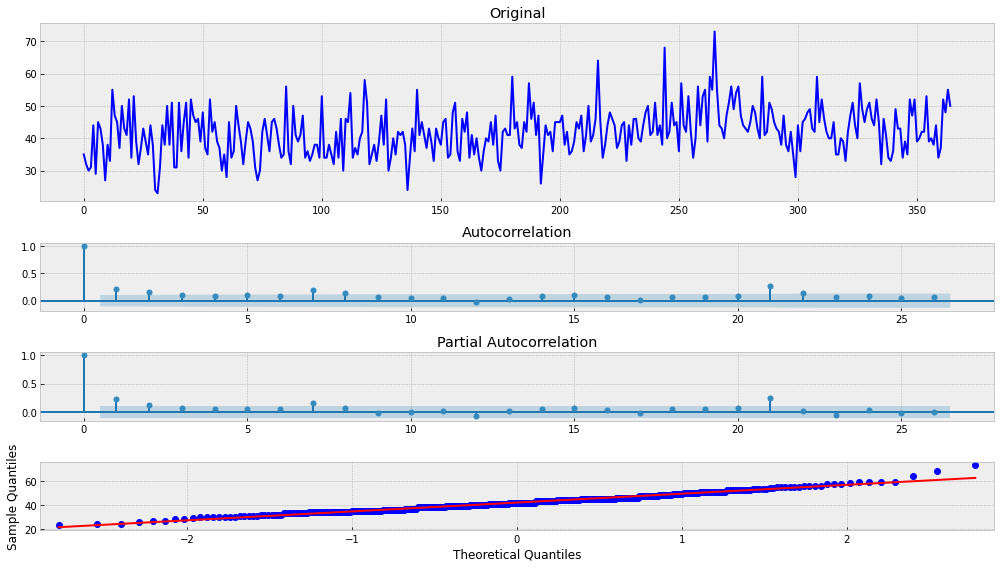

In [5]:
# Проведём анализ веменного ряда
tsplot(series)

Данный временной ряд является стационарным.

In [6]:
# Обучаем модель ьез подбора параметров
am = arch_model(series)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: 1244.5926769082298
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1244.113237179952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1244.1098701015571
            Iterations: 14
            Function evaluations: 75
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Count   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1244.11
Distribution:                  Normal   AIC:                           2496.22
Method:            Maximum Likelihood   BIC:                           2511.82
                                        No. Observations:                  365
Date:                Tue, Feb 01 2022   Df Residuals:                      364
Time:        

In [7]:
# Для подбора параметров применим ARIMA к временному ряду
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: 2452.86333 | order: (3, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.820386e+01
p-value                        2.402095e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


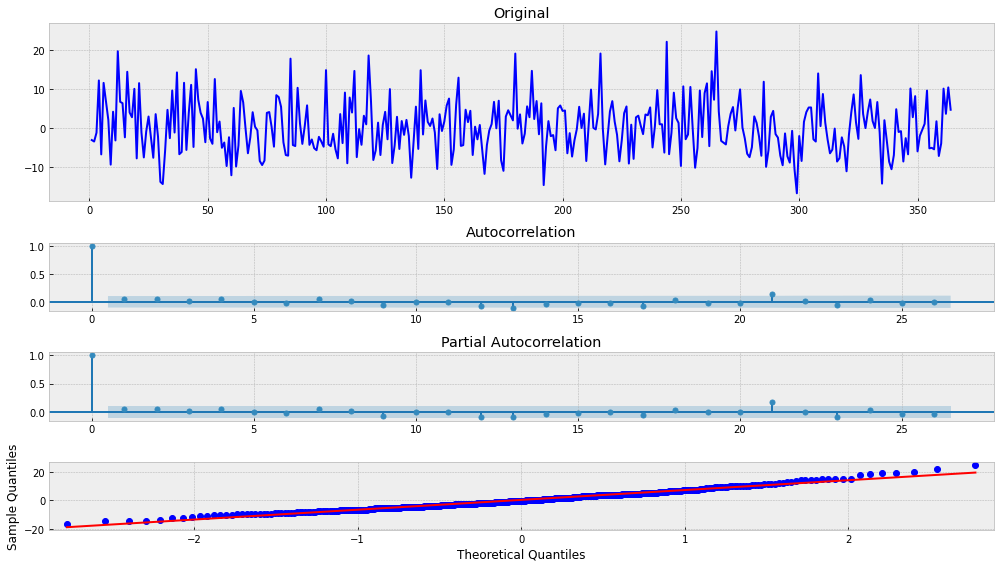

In [8]:
# Строим график остатков
tsplot(mdl.resid)

In [9]:
# Обучаем GARCH с лучшими параметрами
am = arch_model(series, p=3, o=1, q=4, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1241.35
Distribution:      Standardized Student's t   AIC:                           2504.70
Method:                  Maximum Likelihood   BIC:                           2547.60
                                              No. Observations:                  365
Date:                      Tue, Feb 01 2022   Df Residuals:                      364
Time:                              04:10:48   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


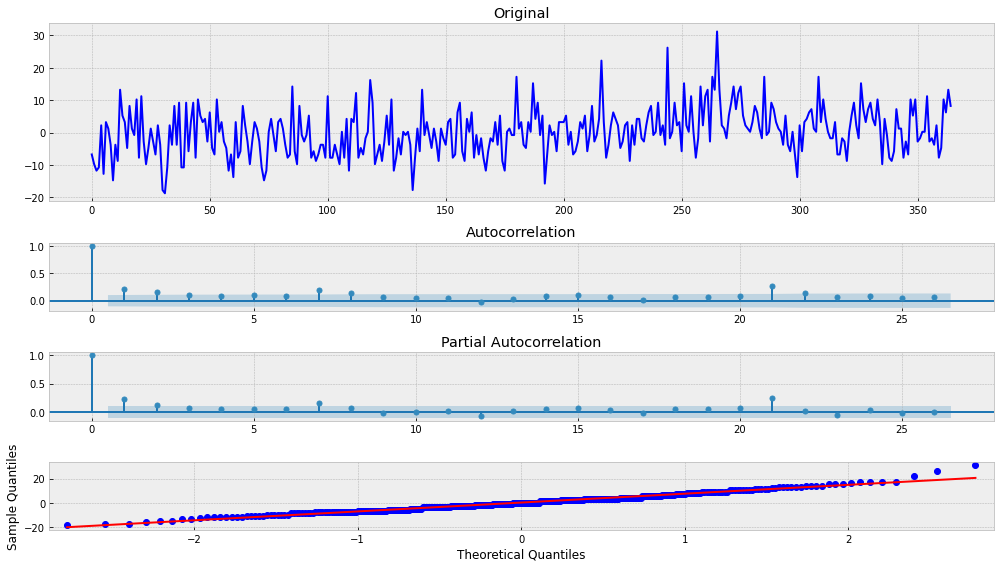

In [10]:
# Строим график остатков
tsplot(res.resid)

Получили нормально распределенные остатки. Следовательно, можно считать, что модель подходит для решения данной задачи.